Pairs trading strategy created by Kris Longmore.
Python version of blog post: https://robotwealth.com/kalman-filter-pairs-trading-r/

In [11]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import pandas_datareader as pdr
import quantstats as qs

import warnings
warnings.filterwarnings("ignore")
qs.extend_pandas()

### Load data

In [12]:
def load_daily_data(ticker):
    df = pdr.DataReader(ticker, 'yahoo', start = '1996-01-01')[['Open','High','Low','Close','Volume','Adj Close']].reset_index()
    df['Ratio'] = df['Adj Close'] / df['Close']
    df['Open'] = df['Open'] * df['Ratio']
    df['High'] = df['High'] * df['Ratio']
    df['Low'] = df['Low'] * df['Ratio']
    df['Close'] = df['Close'] * df['Ratio']
    df = df.drop(['Ratio', 'Adj Close'], axis = 1)
    df.columns = ['date','open','high','low','close','volume']
    df = df.set_index(['date'])
    df = df.dropna()
    
    return df

### Kalman Algorithm

In [13]:
def KalmanStrategy(tickers, scale = 1., plots = True):
    xy = pd.DataFrame(index = load_daily_data(tickers[0]).index)
    xy[tickers[0]] = load_daily_data(tickers[0]).close;xy[tickers[1]] = load_daily_data(tickers[1]).close;xy.dropna(inplace=True)
    x = np.array([np.zeros(len(xy)) + 1, xy[tickers[0]].values]).T; y = xy[tickers[1]].values
    
    delta = 0.0001
    Vw = delta/(1-delta)*np.eye(2)
    Ve = 0.001
    R = np.zeros((2,2))
    P = np.zeros((2,2))
    beta = np.zeros((y.shape[0], 2))
    y_est = np.zeros(y.shape[0])
    e = np.zeros(y.shape[0])
    Q = np.zeros(y.shape[0])
    
    for i in range(len(y)):
        if i > 0:
            beta[i,:] = beta[i - 1,:]
            R = P + Vw
        
        y_est[i] = np.dot(x[i,:], beta[i,:])
        Q[i] = np.dot(x[i,:], np.dot(R, x[i,:].T)) + Ve
        
        e[i] = y[i] - y_est[i]
        K =  np.dot(R, x[i,:].T) / Q[i]
        
        beta[i,:] = beta[i,:] + (K * e[i])
        P = R - np.dot(np.dot(K, x[i,:]), R)
        
    beta = pd.DataFrame(data = beta, index = xy.index);beta.columns = ['UpdInterc', 'UpdHedgeR']
    
    e = pd.DataFrame(data = e, index = xy.index)
    sqrtQ = pd.DataFrame(data = scale*np.sqrt(Q), index = xy.index)
    signals = pd.concat([e,sqrtQ, -sqrtQ], axis = 1, ignore_index = True)
    signals.columns = ["e", "sqrtQ", "negsqrtQ"]
    
    signals['sig'] = np.where((signals.e > signals.sqrtQ) & (signals.e.shift(1) < signals.sqrtQ.shift(1)), -1, 
               np.where((signals.e < signals.negsqrtQ) & (signals.e.shift(1) > signals.negsqrtQ.shift(1)), 1, np.NaN))
    
    sig = signals.sig.fillna(method='ffill');signals.sig = signals.sig.diff()/2
    
    ## simulate positions and pnl
    sim = pd.concat([sig.shift(1), beta.UpdHedgeR, xy[tickers[0]], xy[tickers[1]]], axis = 1)
    sim['posX'] = sim.sig * -1000 * sim.UpdHedgeR
    sim['posY'] = sim.sig * 1000   
    sim.posX[sim.posX == 0] = np.NaN
    sim.posX = sim.posX.fillna(method='ffill')
    sim.posY[sim.posY == 0] = np.NaN
    sim.posY = sim.posY.fillna(method='ffill')
    pnlX = sim.posX * sim[tickers[0]].diff()
    pnlY = sim.posY * sim[tickers[1]].diff()
    pnl = pnlX + pnlY;pnl.dropna(inplace = True)
    pnl.iloc[0] = np.floor(1000 * (sim[tickers[0]].head(1).values*sim.UpdHedgeR.head(1).values 
                          + sim[tickers[1]].head(1).values))
    
    if plots:
        plt.scatter(xy[tickers[0]].pct_change(), xy[tickers[1]].pct_change(),label = tickers)
        plt.legend();plt.show()
        plt.plot(signals[["e", "sqrtQ", "negsqrtQ"]].iloc[5:])
        plt.legend();plt.show()
        plt.plot(pnl.cumsum(), label = "Cumulative PnL, $")
        plt.legend();plt.show()
        
        return qs.plots.snapshot(pnl.cumsum().pct_change())
    
    else:
        
        return pnl.cumsum()

### Performance

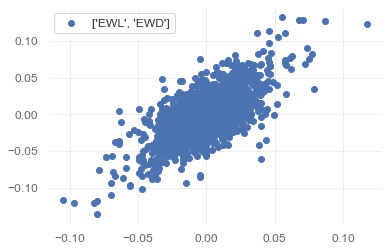

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


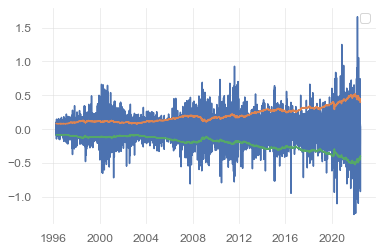

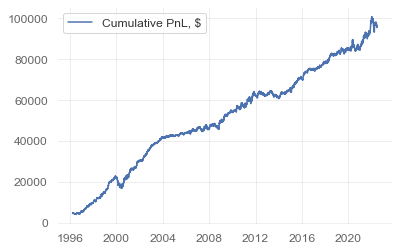

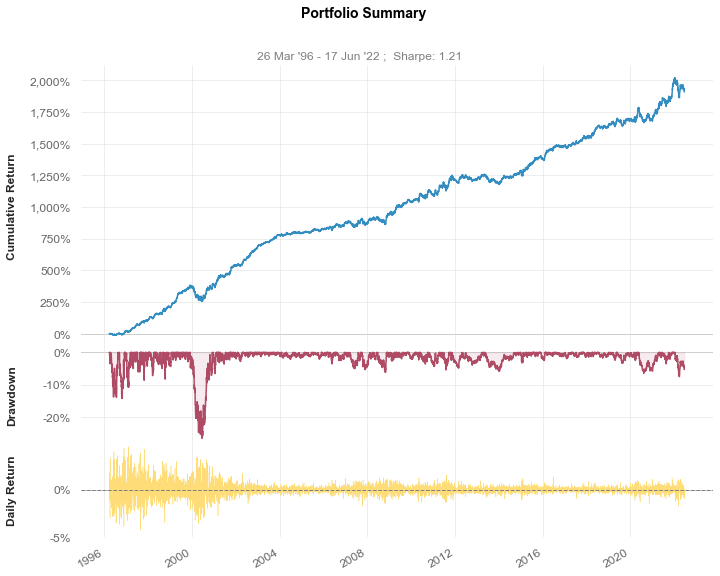

In [14]:
symbols = ['EWL', 'EWD'] # Switzerland vs Sweden
KalmanStrategy(tickers = symbols, scale = 1., plots = True)

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2012-02-16  2012-02-16
End Period                 2022-06-17  2022-06-17
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          158.51%     228.1%
CAGR﹪                     9.62%       12.18%

Sharpe                     2.12        0.77
Prob. Sharpe Ratio         100.0%      99.4%
Smart Sharpe               2.11        0.77
Sortino                    3.4         1.07
Smart Sortino              3.39        1.06
Sortino/√2                 2.41        0.76
Smart Sortino/√2           2.39        0.75
Omega                      1.43        1.43

Max Drawdown               -5.59%      -33.72%
Longest DD Days            298         272
Volatility (ann.)          4.39%       16.69%
R^2                        0.0         0.0
Information Ratio          -0.01       -0.01
Calmar                     1.72        

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2022-01-04,2022-03-16,2022-05-03,119,-5.585308,-4.699643
2,2016-04-11,2016-10-24,2017-02-03,298,-3.259355,-3.035133
3,2020-11-09,2020-12-22,2021-02-03,86,-3.203068,-3.159530
4,2015-03-23,2015-04-16,2015-06-10,79,-2.613793,-2.423430
5,2019-06-12,2019-09-24,2020-01-16,218,-2.552087,-2.456047


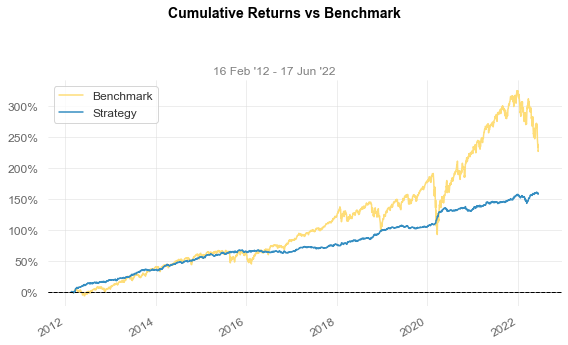

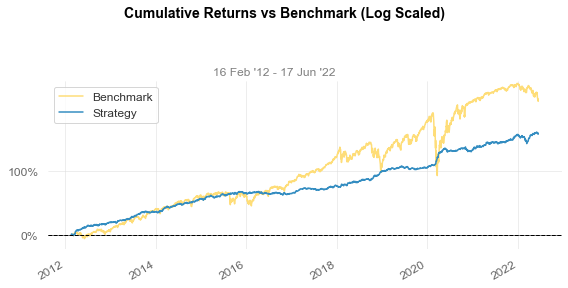

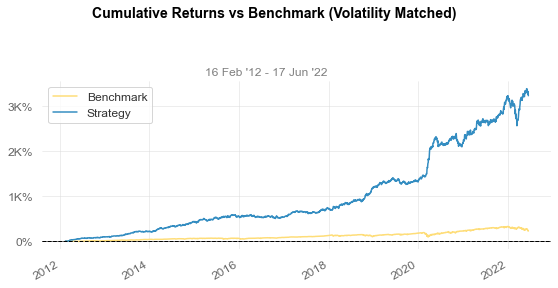

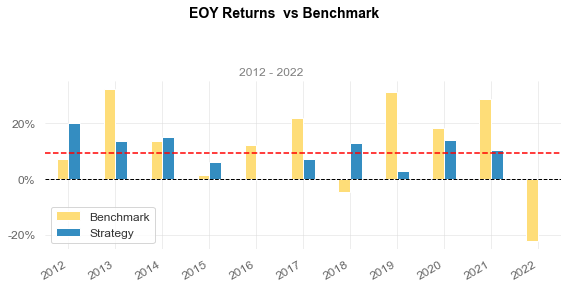

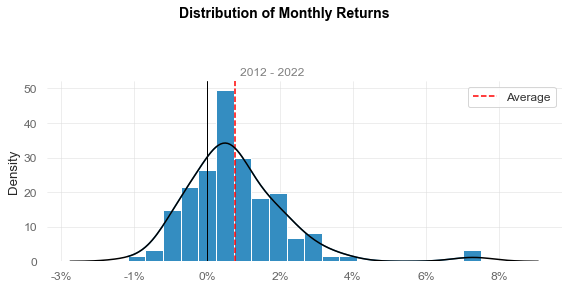

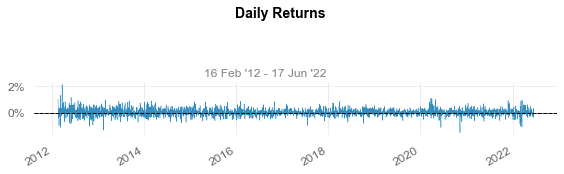

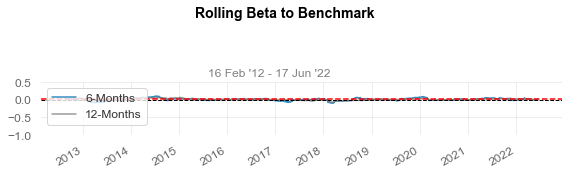

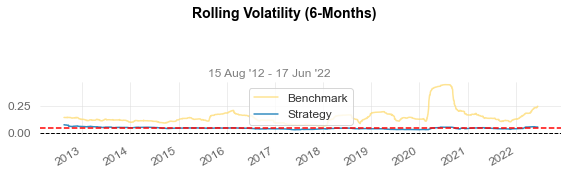

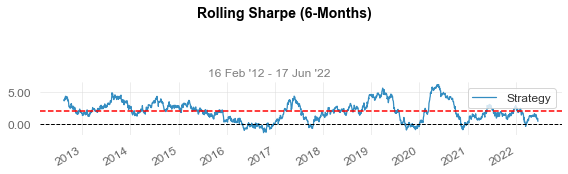

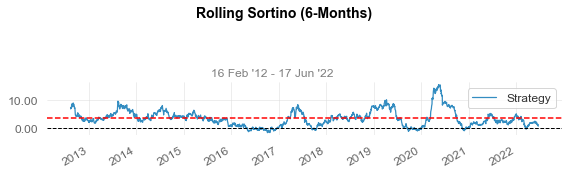

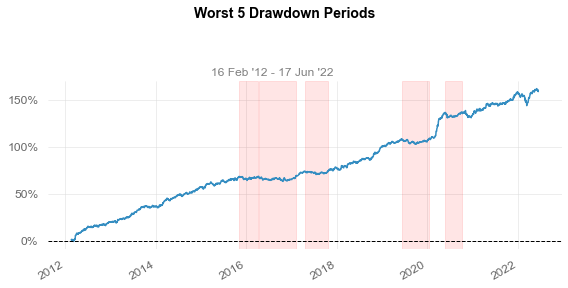

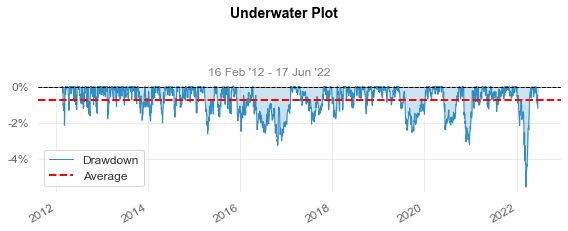

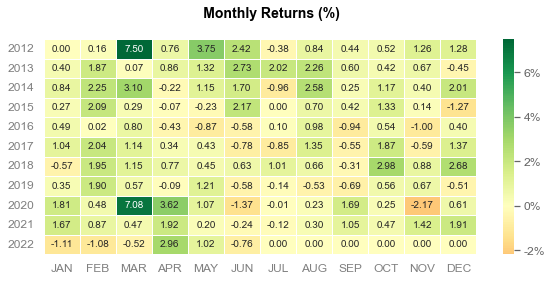

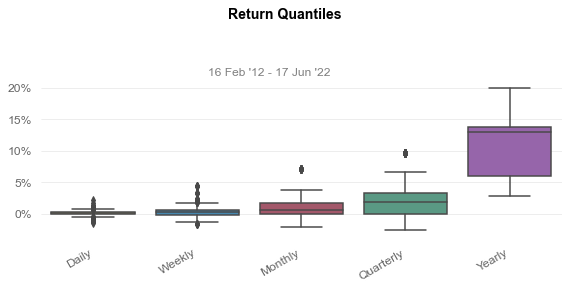

In [15]:
EWCENOR = KalmanStrategy(tickers = ['EWC', 'ENOR'], scale = 0.75, plots = False).pct_change()
EWCSPY = KalmanStrategy(tickers = ['EWC', 'SPY'], scale = 0.5, plots = False).pct_change()
EWDEDEN = KalmanStrategy(tickers = ['EWD', 'EDEN'], scale = 1.25, plots = False).pct_change()
EWLEWD = KalmanStrategy(tickers = ['EWL', 'EWD'], scale = 1.0, plots = False).pct_change()

portfolio = pd.concat([EWCENOR,EWCSPY,EWDEDEN,EWLEWD], axis = 1).dropna()
portfolio['total'] = portfolio.mean(axis = 1)
qs.reports.full(portfolio.total, 'SPY')